In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import tensorflow as tf
from keras import models, layers, callbacks, initializers, regularizers
from keras.layers import ELU, Dense, Dropout, Convolution2D, Input, GlobalAveragePooling2D
from keras.utils import plot_model
from keras.models import Model
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler

import keras.backend as K
import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style="padding:20px;color:white;margin:0;font-size:180%;text-align:center;display:fill;border-radius:5px;background-color:#38A6A5;overflow:hidden;font-weight:500">データの前処理</div>

In [3]:
def preprocess(df:pd.core.frame.DataFrame, istrain:bool) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    if istrain == True:
        target_column = df['Survived']
        df.drop(columns='Survived', inplace=True)

    scaler=StandardScaler()
    df_scaled =pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
    # Survived列を元のDataFrameに結合
    if istrain == True:
        df_scaled['Survived'] = target_column
    return df

df_preprocessed = preprocess(df_train, True)
df_preprocessed_test = preprocess(df_test, False)
df_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [4]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
df_train_x = df_preprocessed
df_train_y = df_train['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

X_test = df_preprocessed_test

In [6]:
from sklearn.model_selection import train_test_split
df_train_x = df_scaled.drop(columns="Survived")
df_train_y = df_scaled['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

NameError: name 'df_scaled' is not defined

In [ ]:
def create_model(num_layer):

    input_shape = x_train.shape[1:]

    model = models.Sequential()

    for i in range(num_layer):
        model.add(Dense(32, activation="relu", input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.25))

    model.add(Dense(1, activation = "sigmoid", name ="output_layer"))

    return model

In [ ]:
# def create_model(n_layer, num_filters, activation, num_regs, dropout_rate):
#     """
#     num_layer : 層の数
#     activation : 活性化関数
#     mid_units : FC層のユニット数
#     num_filters : 各層のフィルタ数
#     """

#     input_shape = x_train.shape[1:]

#     model = Sequential()

#     for i in range(n_layer):
#         model.add(Dense(num_filters[i], activation=activation, input_shape=input_shape), kernel_regularizer=regularizers.l2(num_regs[i]))
#         model.add(Dropout(dropout_rate))

#     model.add(Dense(1, activation = "sigmoid", name ="output_layer"))

#     return model


In [ ]:
def objective(trial):
    num_layer = trial.suggest_int('num_layer', 1, 20) # 追加する層を選ぶ
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam', 'rmsprop']) # 最適化アルゴリズム

    # 学習モデルの構築と学習の開始
    model = create_model(num_layer)
    model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    )
    history = model.fit(x_train, y_train, 
                        verbose=1,
                        epochs=5,
                        validation_data=(x_val, y_val),
                        batch_size=32)

    # 学習モデルの保存
    model_json = model.to_json()
    with open('keras_model.json', 'w') as f_model:
        f_model.write(model_json)
    model.save_weights('keras_model.hdf5')

    # 最小値探索なので
    return -np.amax(history.history['val_acc'])

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-09-05 15:05:57,823] A new study created in memory with name: no-name-a91fc125-bbdc-44d5-92fc-b31de3a5e284


Epoch 1/5
24/24 [==============================] - 3s 24ms/step - loss: 0.8947 - val_loss: 0.8651
Epoch 2/5
24/24 [==============================] - 0s 7ms/step - loss: 0.8688 - val_loss: 0.8565
Epoch 3/5
24/24 [==============================] - 0s 5ms/step - loss: 0.8612 - val_loss: 0.8501
Epoch 4/5
24/24 [==============================] - 0s 4ms/step - loss: 0.8553 - val_loss: 0.8449
Epoch 5/5
24/24 [==============================] - 0s 5ms/step - loss: 0.8500 - val_loss: 0.8408


[W 2023-09-05 15:06:01,463] Trial 0 failed with parameters: {'num_layer': 6, 'optimizer': 'sgd'} because of the following error: KeyError('val_acc').
Traceback (most recent call last):
  File "c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Intern\AppData\Local\Temp\ipykernel_46292\865005582.py", line 23, in objective
    return -np.amax(history.history['val_acc'])
                    ~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'val_acc'
[W 2023-09-05 15:06:01,465] Trial 0 failed with value None.


KeyError: 'val_acc'

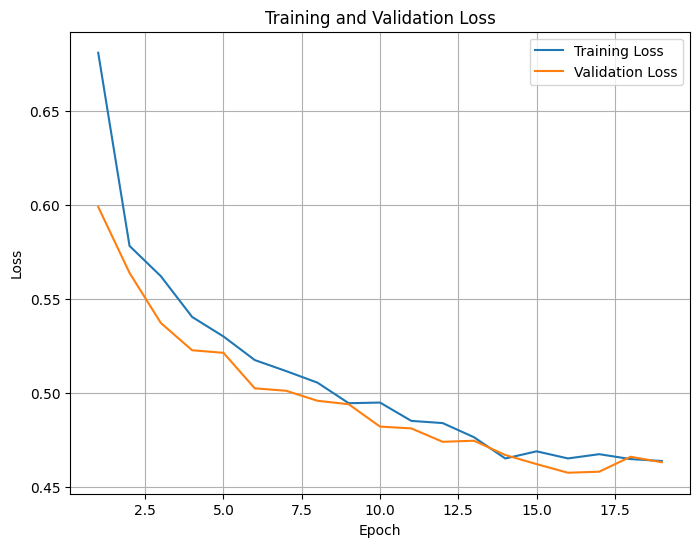

In [ ]:
import matplotlib.pyplot as plt
# lossの変化を取得
train_loss = final.history['loss']
val_loss = final.history['val_loss']

# グラフのプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_processed_test =preprocess(df_test)
df_processed_test =pd.DataFrame(scaler.fit_transform(df_processed_test),columns=df_processed_test.columns)
df_processed_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.873482,0.466044,-0.499470,-0.400248,-0.497063,-0.755929,0.755929,-0.568142,2.843757,-1.350676
1,0.873482,1.415579,0.616992,-0.400248,-0.511926,1.322876,-1.322876,-0.568142,-0.351647,0.740370
2,-0.315819,2.555021,-0.499470,-0.400248,-0.463754,-0.755929,0.755929,-0.568142,2.843757,-1.350676
3,0.873482,-0.103676,-0.499470,-0.400248,-0.482127,-0.755929,0.755929,-0.568142,-0.351647,0.740370
4,0.873482,-0.483490,0.616992,0.619896,-0.417151,1.322876,-1.322876,-0.568142,-0.351647,0.740370


In [ ]:
y_pred = model.predict(df_processed_test)

print(y_pred)

df_submit = pd.DataFrame(predictions,columns=['Survived'])#新たな提出用dfを定義
df_submit.Survived = round(df_submit.Survived)
df_submit

14/14 [==============================] - 0s 1ms/step
[[0.07719863]
 [0.43847468]
 [0.07041793]
 [0.12773381]
 [0.31832564]
 [0.23054826]
 [0.68388397]
 [0.1872317 ]
 [0.63194853]
 [0.11338591]
 [0.15353045]
 [0.23435459]
 [0.93915474]
 [0.06950433]
 [0.9390155 ]
 [0.86346126]
 [0.0868042 ]
 [0.23403414]
 [0.371468  ]
 [0.66057986]
 [0.37257108]
 [0.45300314]
 [0.94301647]
 [0.55178374]
 [0.91841704]
 [0.06057011]
 [0.9436103 ]
 [0.21684176]
 [0.25194705]
 [0.1764829 ]
 [0.08364994]
 [0.16008532]
 [0.19994853]
 [0.2973748 ]
 [0.36486816]
 [0.26551953]
 [0.4722956 ]
 [0.4721675 ]
 [0.13552122]
 [0.19249919]
 [0.12362651]
 [0.43730977]
 [0.08601187]
 [0.8718205 ]
 [0.9391378 ]
 [0.13453302]
 [0.26730585]
 [0.11015535]
 [0.9408925 ]
 [0.30197504]
 [0.42122015]
 [0.18723467]
 [0.77396274]
 [0.8973287 ]
 [0.25240216]
 [0.06196894]
 [0.10183822]
 [0.13436149]
 [0.14046569]
 [0.93994826]
 [0.18955594]
 [0.1348951 ]
 [0.17828049]
 [0.67892337]
 [0.49190688]
 [0.88020706]
 [0.6713671 ]
 [0.24980

,Survived
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
413,0.0
414,1.0
415,0.0
416,0.0


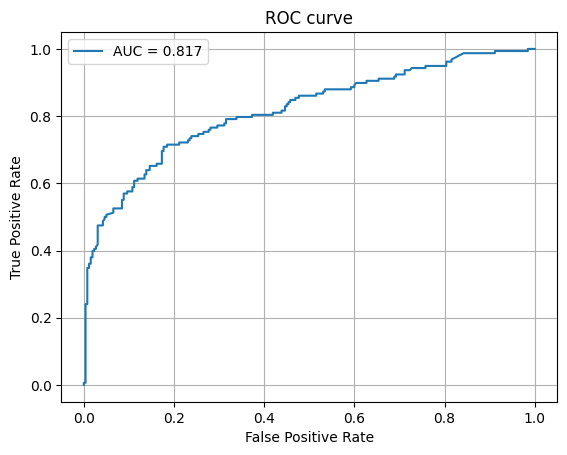

In [ ]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')

Y_test = df_answer['Survived']

Y_test.head()

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_score = roc_auc_score(Y_test, y_pred)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
